In [87]:
%run '/home/jovyan/work/env_load.ipynb'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [88]:
import econmodels as econ

# Market Mix Model 

Market Mix Modeling (MMM) is a statistical technique to help understand the impact of marketing activity across several media channels. MMM's are typically used when it is not possiable to track marketing activity through to sales directly. For example a customer clicks on a link adversting your product in a search engine and then purchases the product. While the search activity is directly trackable the marketing activity that inspired the customer to visit the search engine and look for your product is not. We need to credit the sales between Search and all the non trackable media activity. 

Take an online store that runs TV and Radio adversts to build brand awareness as well as a Search campaign to insure the awareness is converted into sales. The stores' MMM would looks like

$$Sales = \alpha*(TV) + \beta*(Radio) + \gamma*(Search) + error$$

Sales is the weekly sales from the store. Radio, TV and Search is the weekly spend on each of those activities. And, finally $error$ is the amount we are off by when predicting Sales in a given week. The question is what are the values for $\alpha$, $\beta$ and $\gamma$ that will explain Sales as acuractly as possible? Put more mathematically we need to find values of $\alpha$, $\beta$ and $\gamma$ that gives us $\sum error$ = 0

$$ \sum[Sales - (\alpha*(TV) + \beta*(Radio) + \gamma*(Search))]^2 = 0 $$

which leaves us with $\alpha$ as measure of TV's impact, $\beta$ Radios and $\gamma$ for Search.

# Import Data

We begin by importing our data. We require a KPI(s) which in this example is Sales along with the marketing activity  by channel. Here we have Spend, Clicks and Impressions by channel.

To import a file we use 

In [89]:
df = pd.read_excel('../media_spend.xlsx',sheet_name='INPUT',date_parser='Date',index_col='Date')
df = df.round()
df.head(5).T

Date,2014-09-01 00:00:00,2014-09-08 00:00:00,2014-09-15 00:00:00,2014-09-22 00:00:00,2014-09-29 00:00:00
KPI_Sales,3945,4605,3701,5810,6571
Affiliates_Spend,3161,10653,12712,4001,3446
Affiliates_Clicks,18826,24565,17162,8252,7523
Apple_Search_Clicks,12737,12870,14191,9769,16809
Apple_Search_Spend,1448,1265,1204,1034,1545
Cinema_Admissions_brand,0,0,0,0,0
Cinema_Spend_brand,0,0,0,0,0
Facebook_Impressions,0,0,0,0,0
Facebook_Clicks,15161,25859,22650,16306,29510
Facebook_Spend,8880,14859,13757,11431,21882


We begin by split our variables into groups. The Taxi_groups function can help us with this. It will take a list of our features and the split them into lists depending on each features name. For example features begining with "kpi_" will be grouped into a list called kpis, while "_spend" will be grouped into a spend list

In [90]:
(kpis, spends,impacts,clicks,adstock) = econ.misc.Taxi_groups(list(df.columns),['kpi_','_spend','_impressions','_click','_brand'])

In [91]:
spends

['Affiliates_Spend',
 'Apple_Search_Spend',
 'Cinema_Spend_brand',
 'Facebook_Spend',
 'Google_Mobile_Search_Spend',
 'Gmail_Spend',
 'Youtube_Spend',
 'Instagram_Spend',
 'OOH_Spend_brand',
 'Digital_Display_Spend',
 'Retargeting_Spend',
 'Pinterest_Spend',
 'Radio_Spend_brand',
 'Search_Brand_Spend',
 'Search_Generic_Spend',
 'TV_Spend_brand',
 'Twitter_Spend',
 'VOD_Spend']

In [92]:
df = df.round(2)

# AdStock 

As not all spend will results in a sale with the date period of measurement we need to distrubute spend across time periods, this is called AdStock. Think about seeing an advert for a hotel chain in a Cinema, you cannot book the hotel while watching the moving but you may go home and think about it for a couple of weeks then book the holiday. 

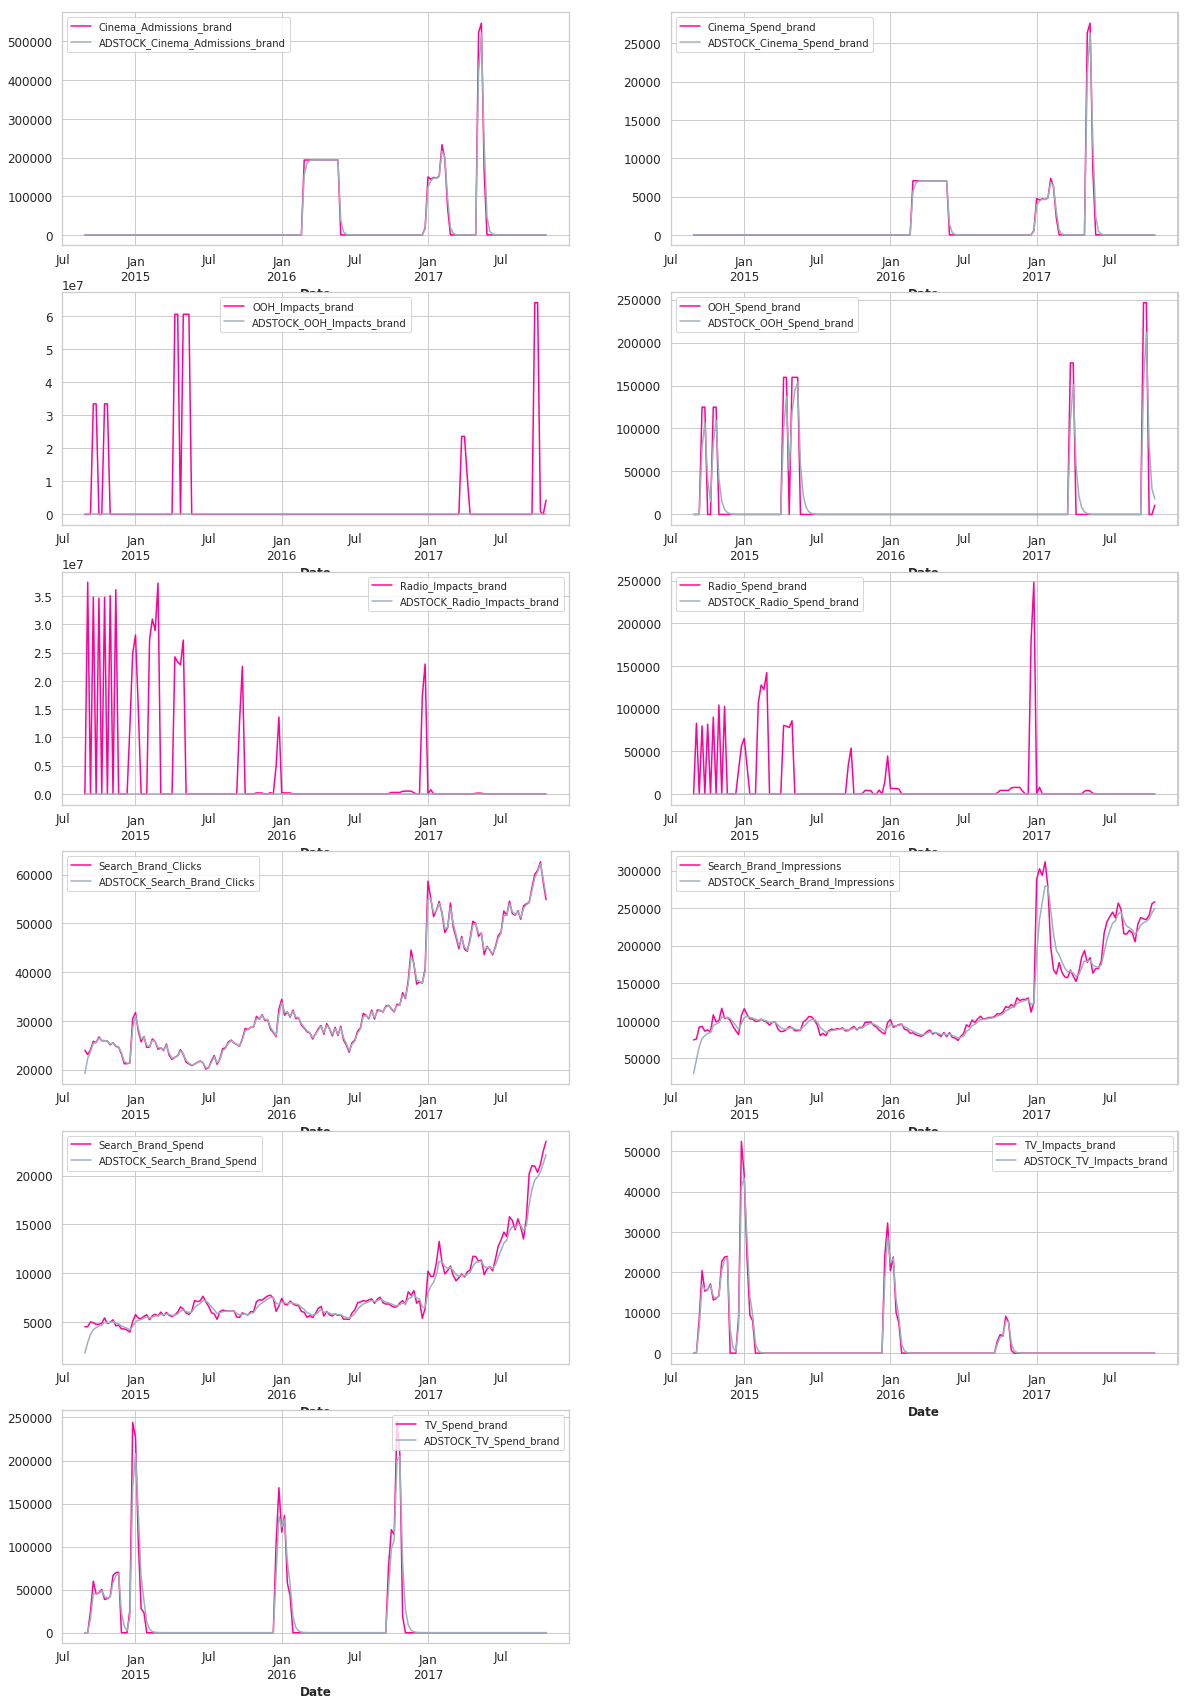

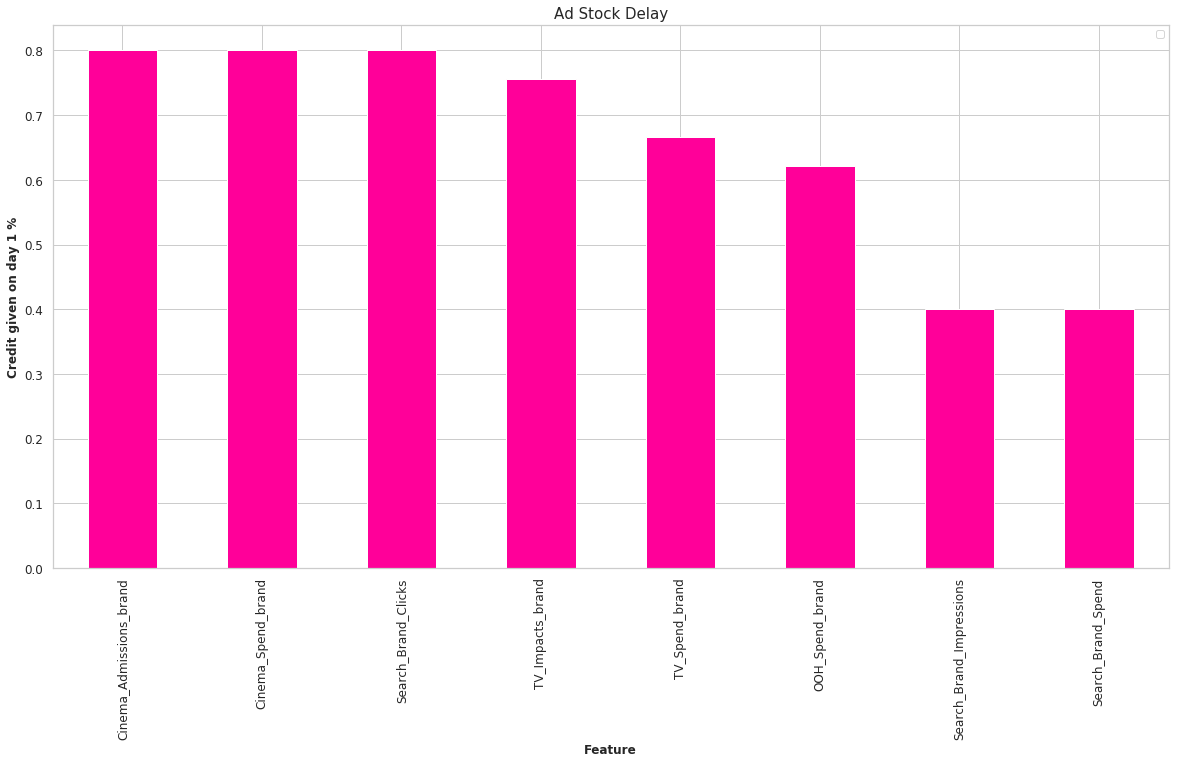

In [93]:
(df_adstock_summary, df_adstock) = econ.adstock.Adstock(df[adstock],df[kpis[0]])

econ.adstock.Adstock_feature_plot(df,df_adstock)
econ.adstock.Adstock_summary_plot(df_adstock_summary,size=(20,10),cmap=my_cmap)

df[adstock] = df_adstock

# Fit Model

Before fitting our model we begin by splitting our data into two groups. One to train another to fit. We check the pvals of our splits to check we have two simmilar groups. The pval should be less the 0.05

In [94]:
(train,test,p_val) = econ.misc.Split(df,kpis)
print("Pval is " + str(p_val))

Pval is 0.0067423106599047555


## Selecting Features

next we create a list of the features we wish to have has inputs into our model. In this case we will take the spend metrics and included a seasonality flag so our fill list looks like. 

                                      Plots for Affiliates_Spend                                      


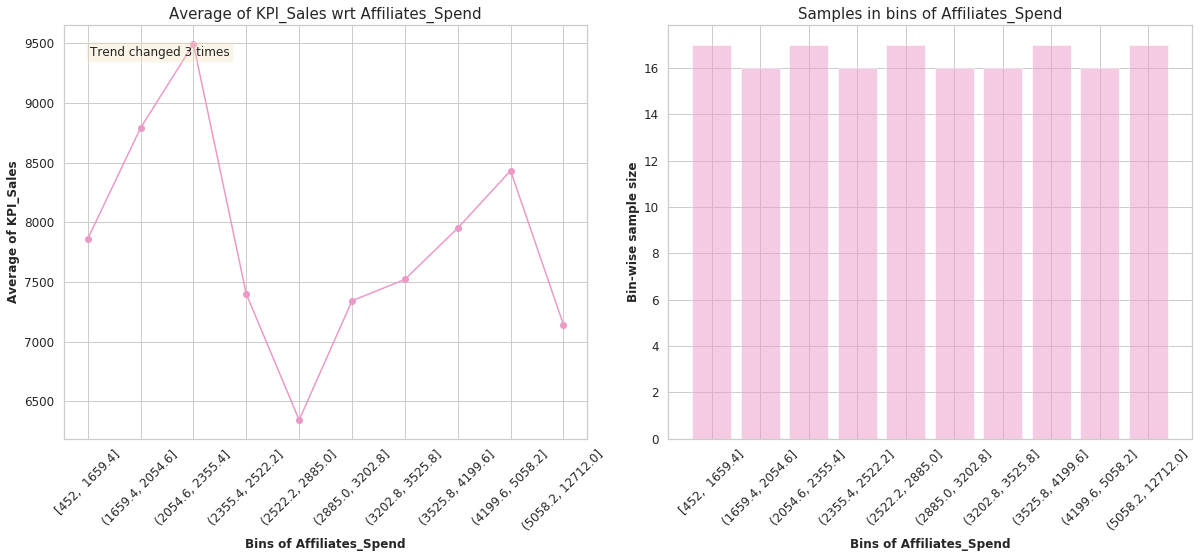

--------------------------------------------------------------------------------------------------------------


                                     Plots for Apple_Search_Spend                                     


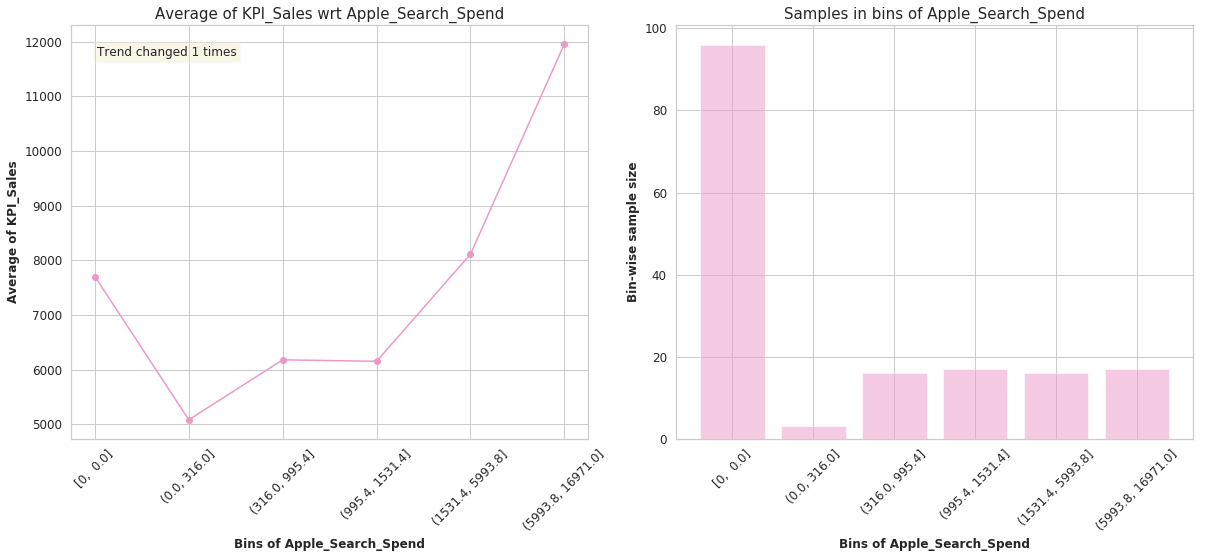

--------------------------------------------------------------------------------------------------------------


                                     Plots for Cinema_Spend_brand                                     


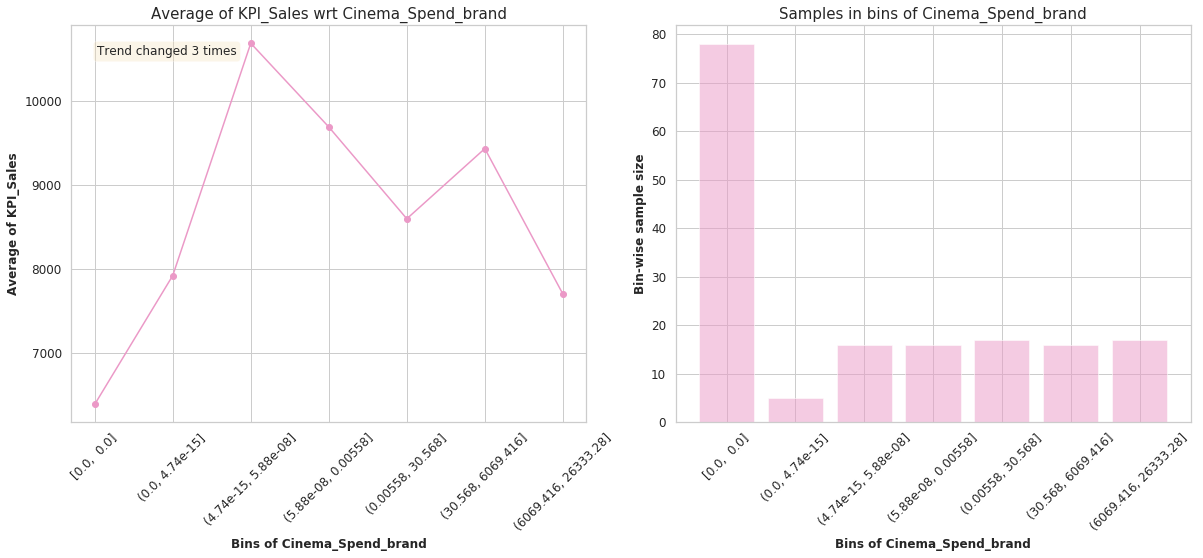

--------------------------------------------------------------------------------------------------------------


                                       Plots for Facebook_Spend                                       


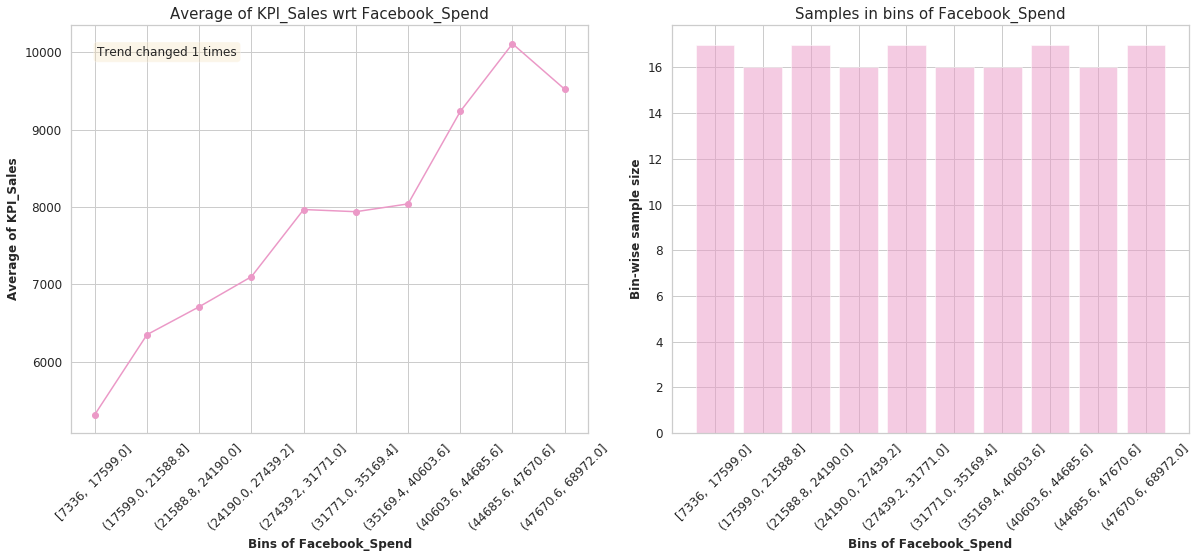

--------------------------------------------------------------------------------------------------------------


                                 Plots for Google_Mobile_Search_Spend                                 


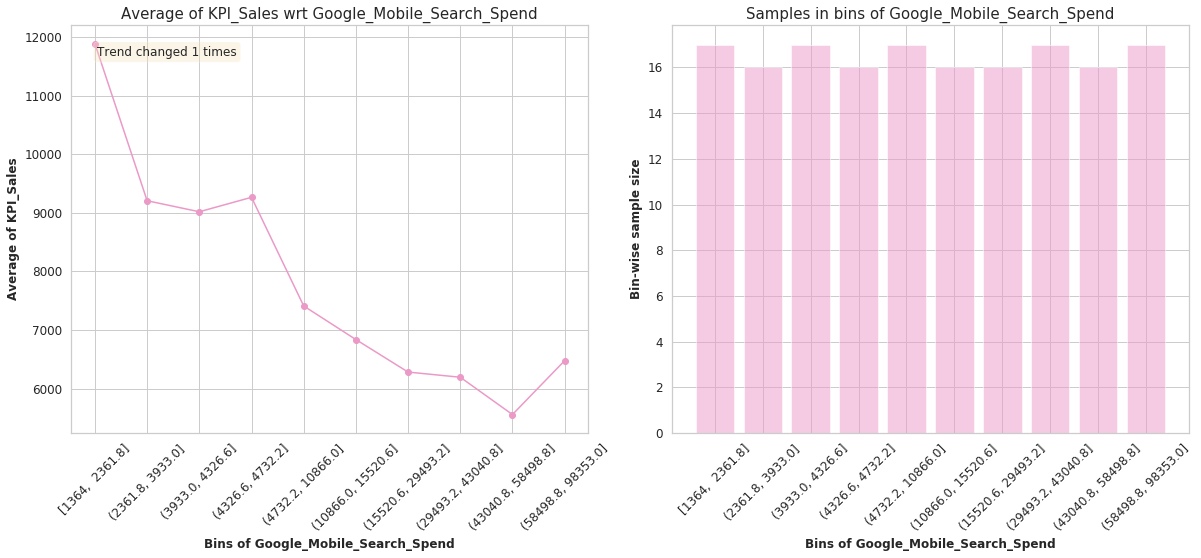

--------------------------------------------------------------------------------------------------------------


                                        Plots for Gmail_Spend                                         


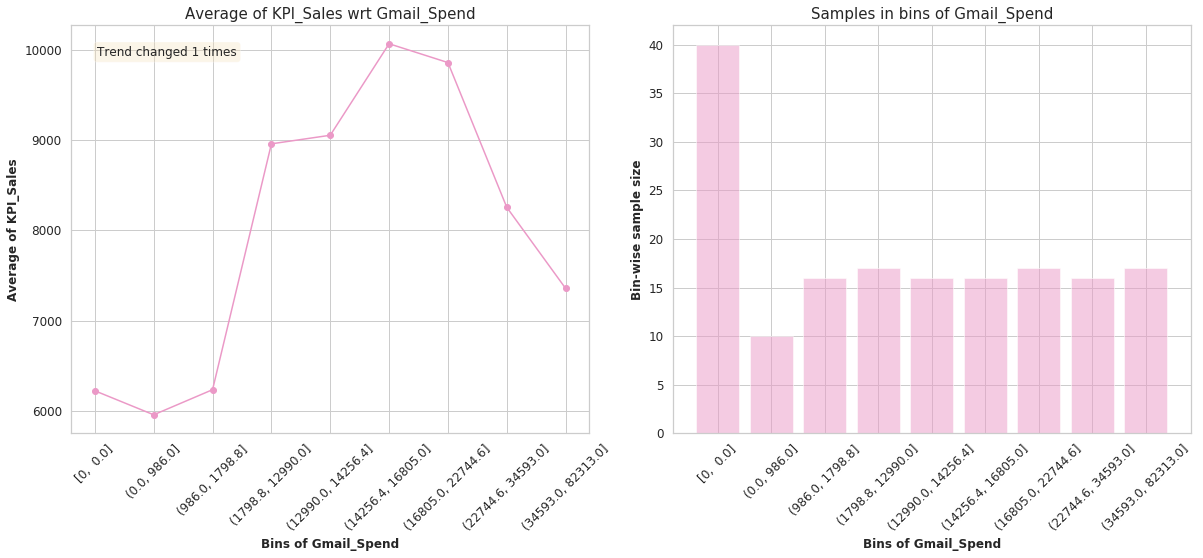

--------------------------------------------------------------------------------------------------------------


                                       Plots for Youtube_Spend                                        


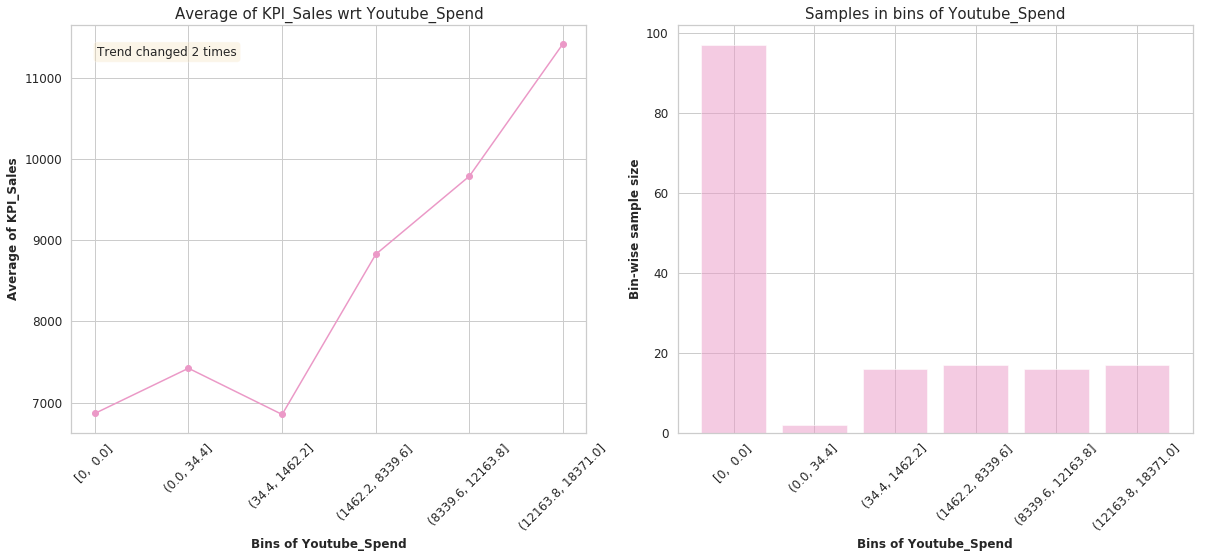

--------------------------------------------------------------------------------------------------------------


                                      Plots for Instagram_Spend                                       


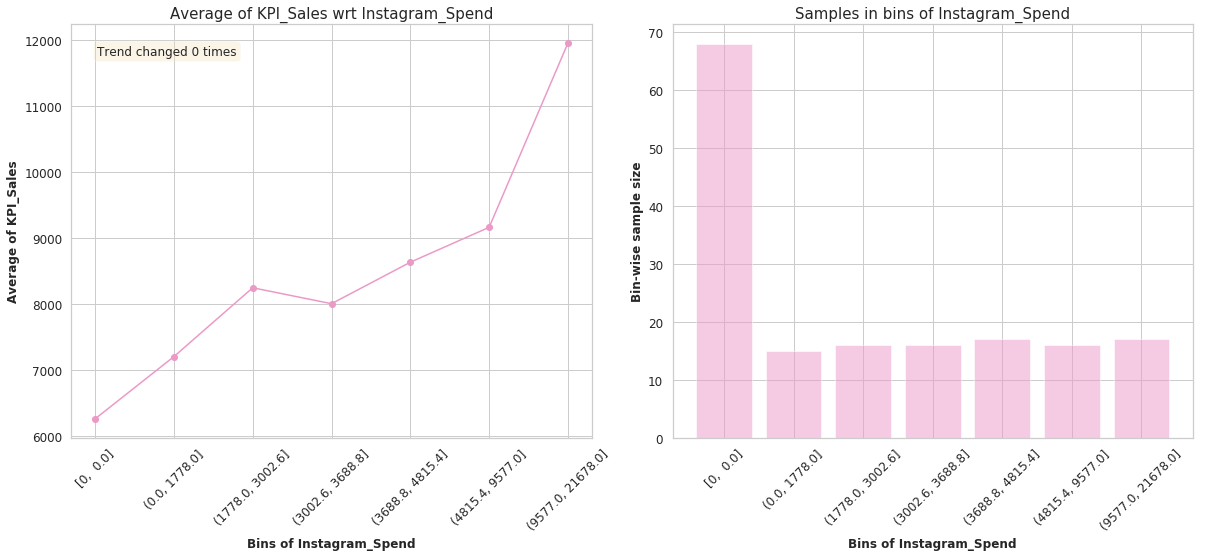

--------------------------------------------------------------------------------------------------------------


                                      Plots for OOH_Spend_brand                                       


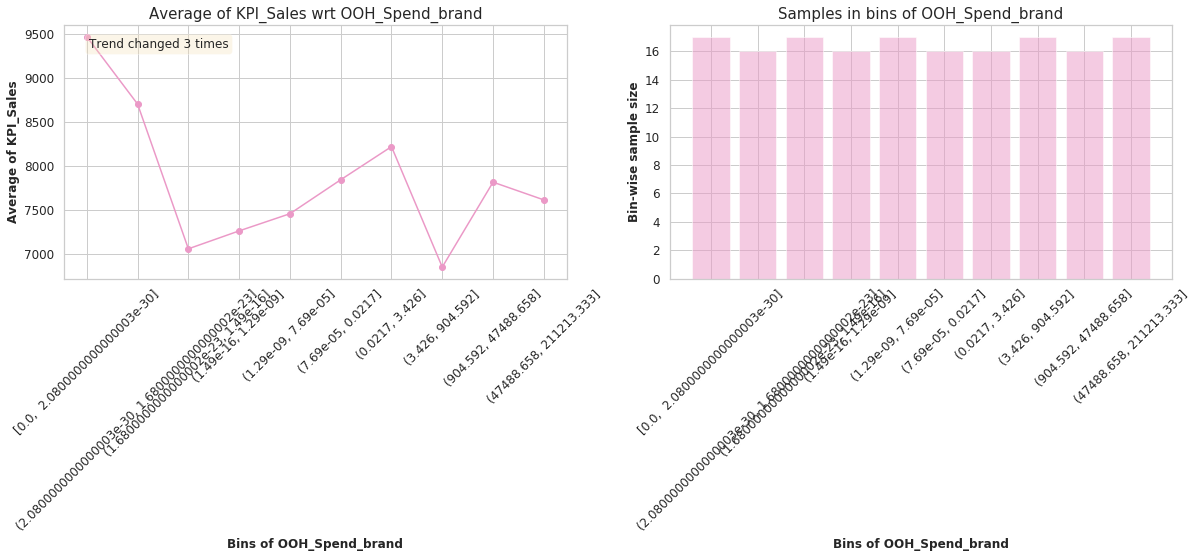

--------------------------------------------------------------------------------------------------------------


                                   Plots for Digital_Display_Spend                                    


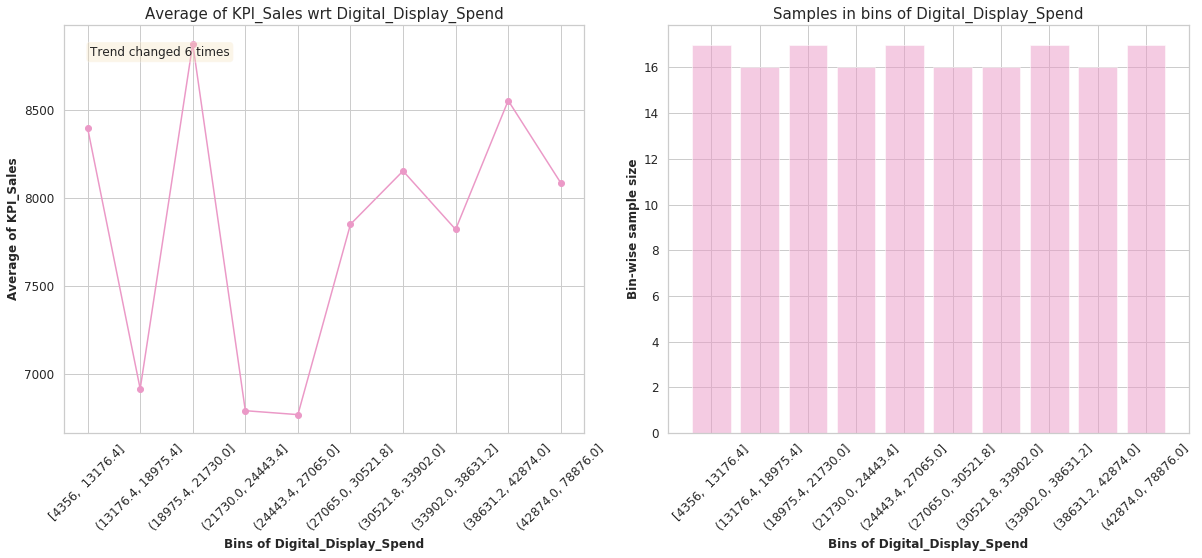

--------------------------------------------------------------------------------------------------------------


                                     Plots for Retargeting_Spend                                      


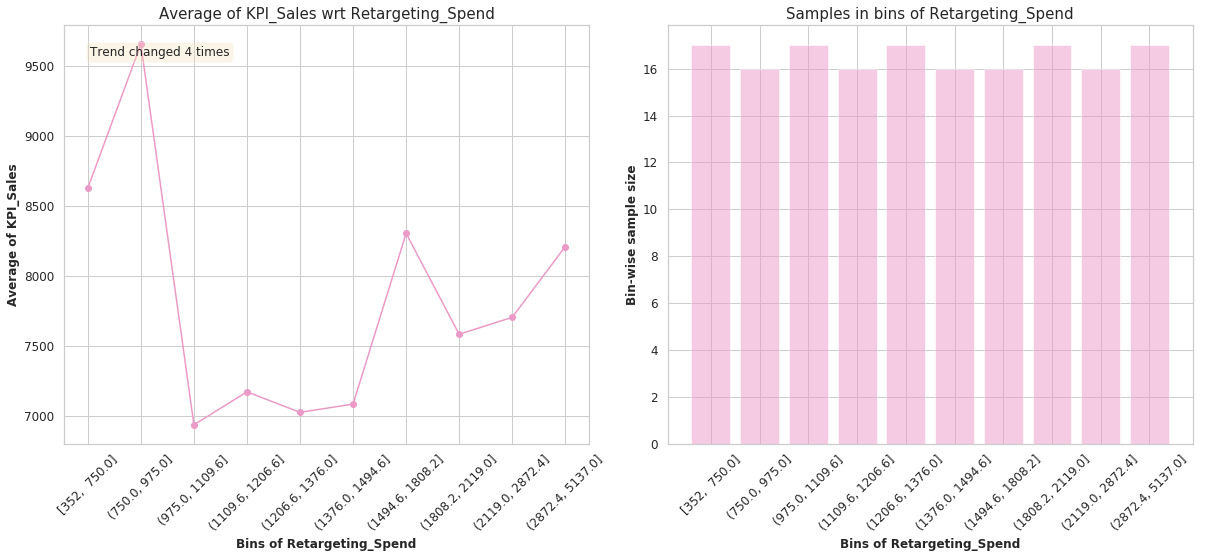

--------------------------------------------------------------------------------------------------------------


                                      Plots for Pinterest_Spend                                       


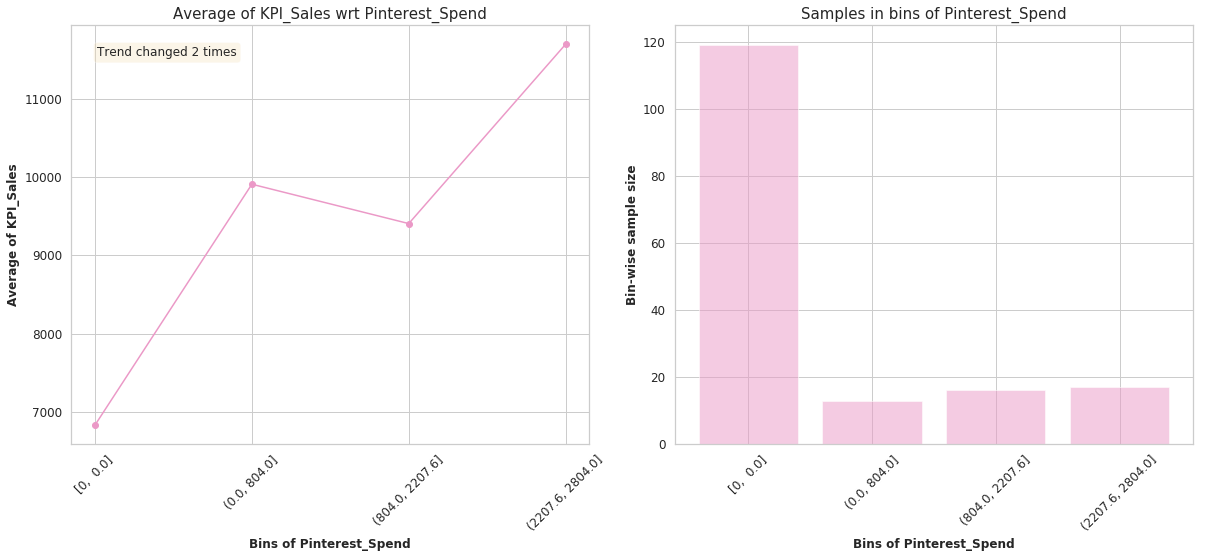

--------------------------------------------------------------------------------------------------------------


                                     Plots for Radio_Spend_brand                                      


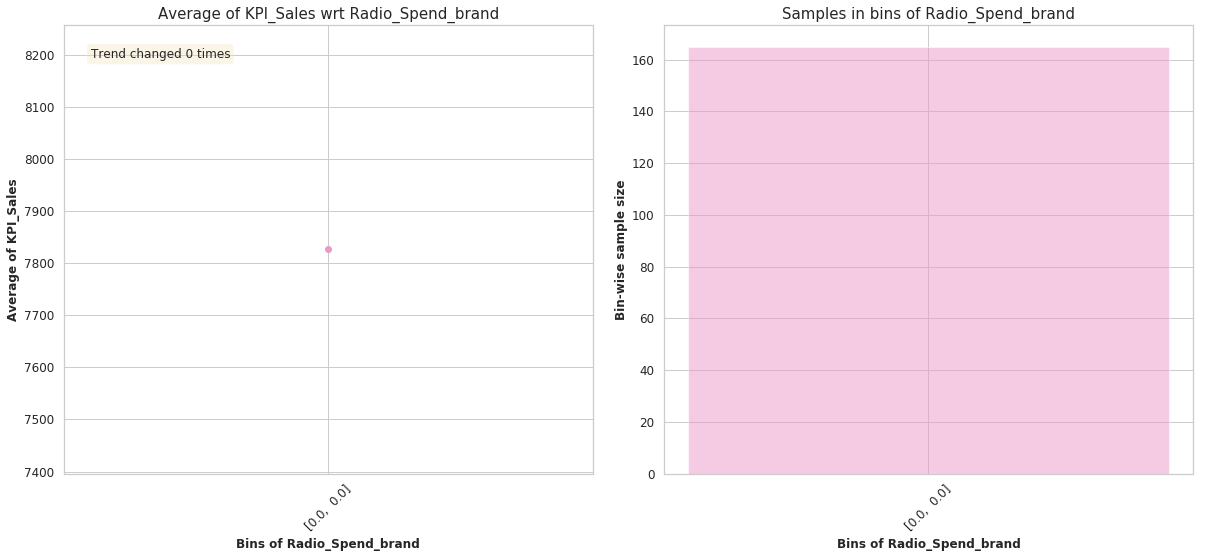

--------------------------------------------------------------------------------------------------------------


                                     Plots for Search_Brand_Spend                                     


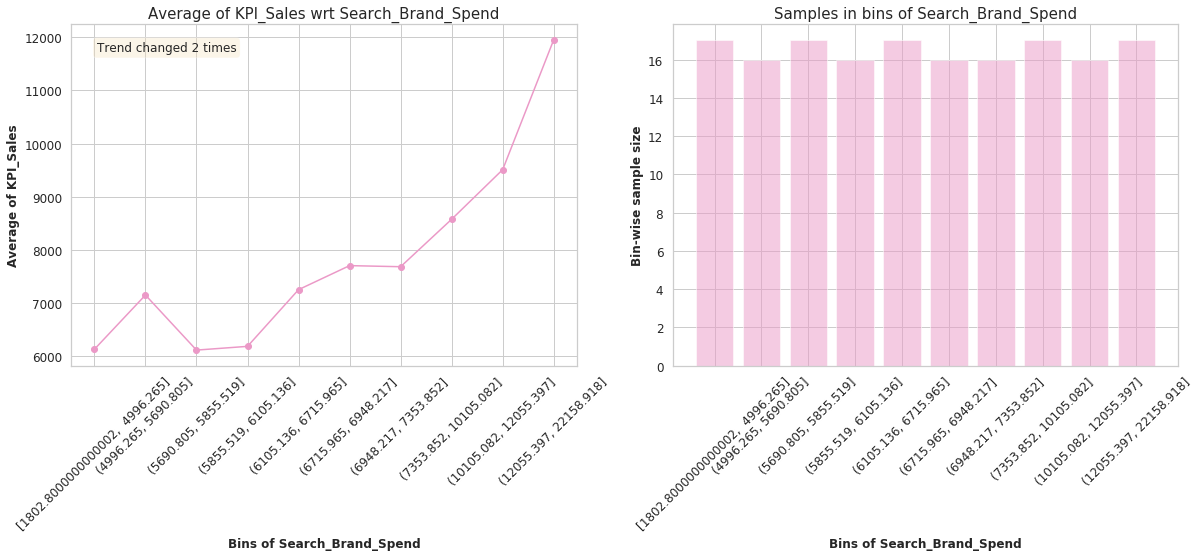

--------------------------------------------------------------------------------------------------------------


                                    Plots for Search_Generic_Spend                                    


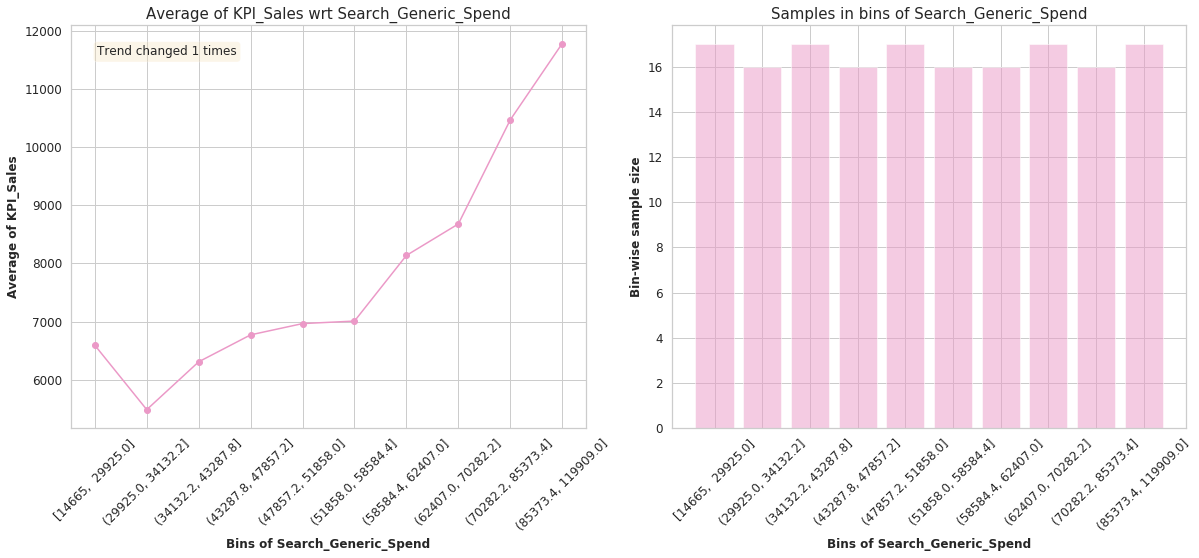

--------------------------------------------------------------------------------------------------------------


                                       Plots for TV_Spend_brand                                       


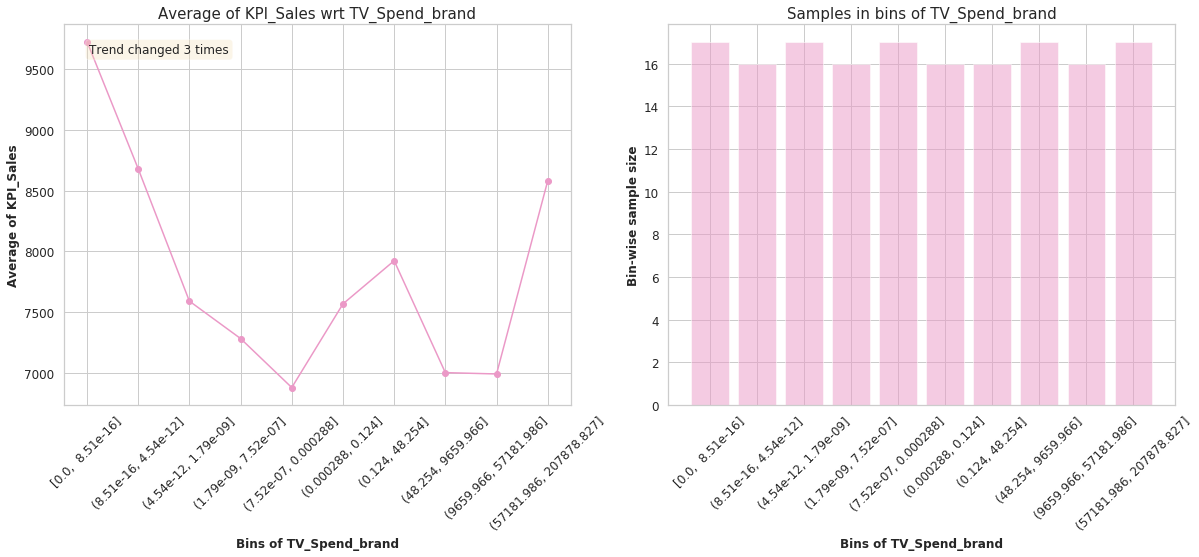

--------------------------------------------------------------------------------------------------------------


                                       Plots for Twitter_Spend                                        


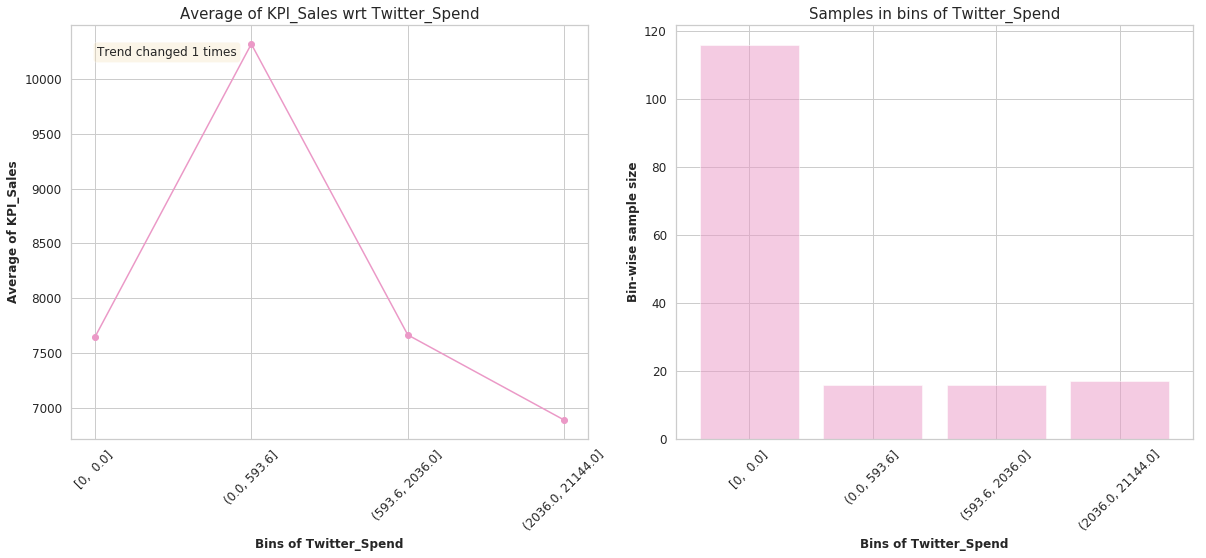

--------------------------------------------------------------------------------------------------------------


                                         Plots for VOD_Spend                                          


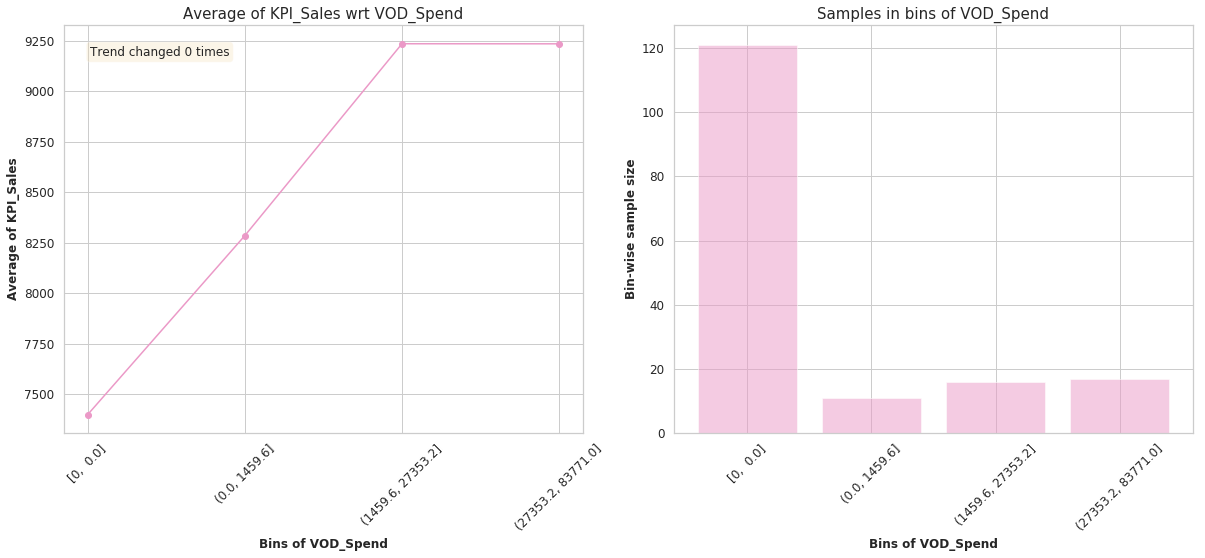

--------------------------------------------------------------------------------------------------------------




In [95]:
#econ.features.Get_univariate_plots(data=train, target_col=kpis[0], data_test=test, features_list=spends,c=color_dict['pink'])
econ.features.Get_univariate_plots(data=df, target_col=kpis[0], features_list=spends,c=color_dict['pink'])

In [96]:
stats = econ.features.Get_trend_stats(data=train, target_col=kpis[0], data_test=test)
stats.sort_values(by='Trend_correlation',ascending=False)

Only one bin created for OOH_Impacts_brand. Correlation can't be calculated
Only one bin created for Pinterest_Impressions. Correlation can't be calculated
Only one bin created for Radio_Impacts_brand. Correlation can't be calculated
Only one bin created for Radio_Spend_brand. Correlation can't be calculated


,Feature,Trend_changes,Trend_changes_test,Trend_correlation
16,Youtube_Impressions,1,0,1.000000
42,Twitter_Impressions,1,1,0.994730
3,Apple_Search_Spend,1,1,0.992120
15,Youtube_Clicks,0,0,0.987119
33,Search_Brand_Impressions,0,2,0.982429
18,Instagram_Clicks,4,2,0.982363
32,Search_Brand_Clicks,0,2,0.977020
37,Search_Generic_Spend,0,1,0.962415
27,Pinterest_Clicks,2,2,0.958457
35,Search_Generic_Clicks,0,2,0.943281


In [97]:
independent = spends
independent.append('Seasonal')
independent

['Affiliates_Spend',
 'Apple_Search_Spend',
 'Cinema_Spend_brand',
 'Facebook_Spend',
 'Google_Mobile_Search_Spend',
 'Gmail_Spend',
 'Youtube_Spend',
 'Instagram_Spend',
 'OOH_Spend_brand',
 'Digital_Display_Spend',
 'Retargeting_Spend',
 'Pinterest_Spend',
 'Radio_Spend_brand',
 'Search_Brand_Spend',
 'Search_Generic_Spend',
 'TV_Spend_brand',
 'Twitter_Spend',
 'VOD_Spend',
 'Seasonal']

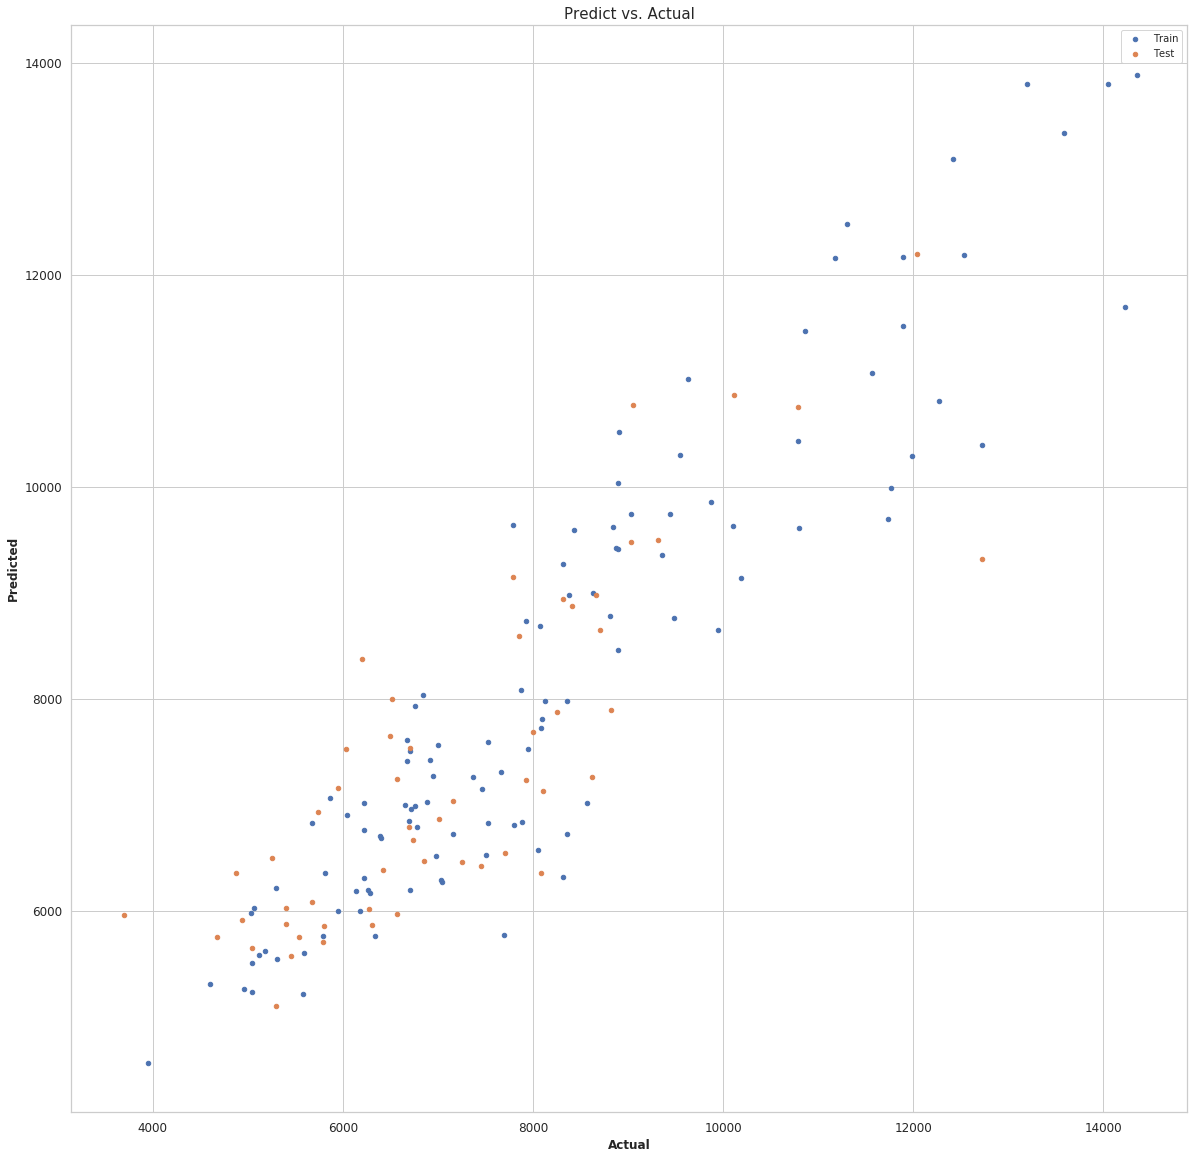

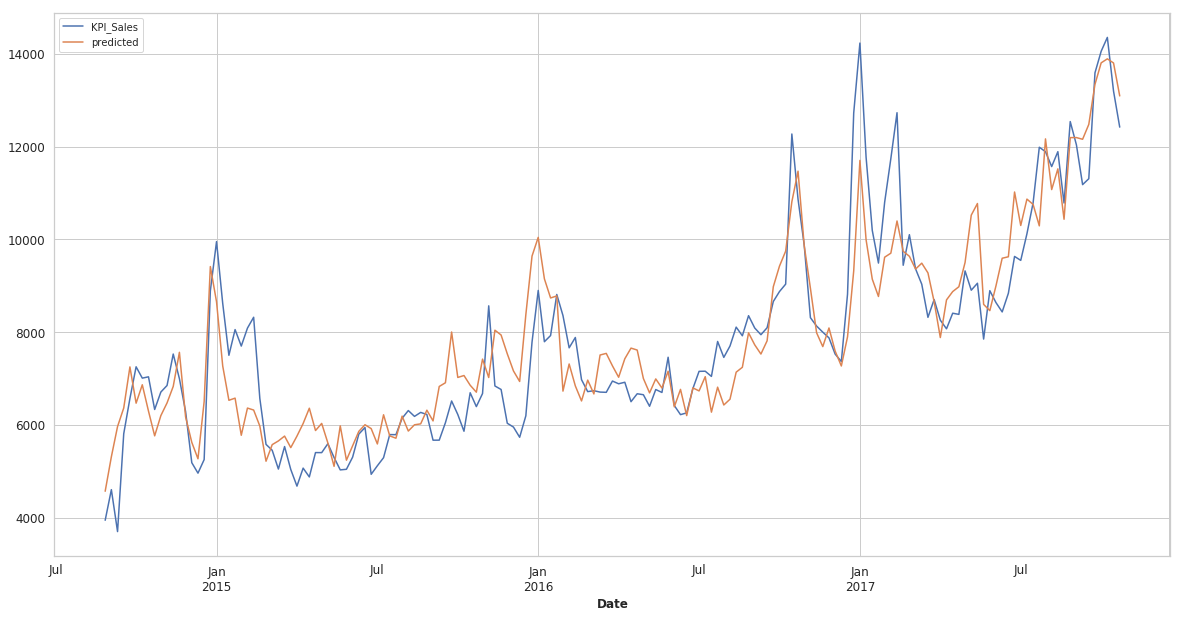

In [98]:
target = kpis[0]

(res,model_summary) = econ.models.FitModel_Lasso(train,test,target,independent,size=(20,20))
df['predicted'] = res.predict(df[independent])
df[[target,'predicted']].plot(figsize=(20,10))

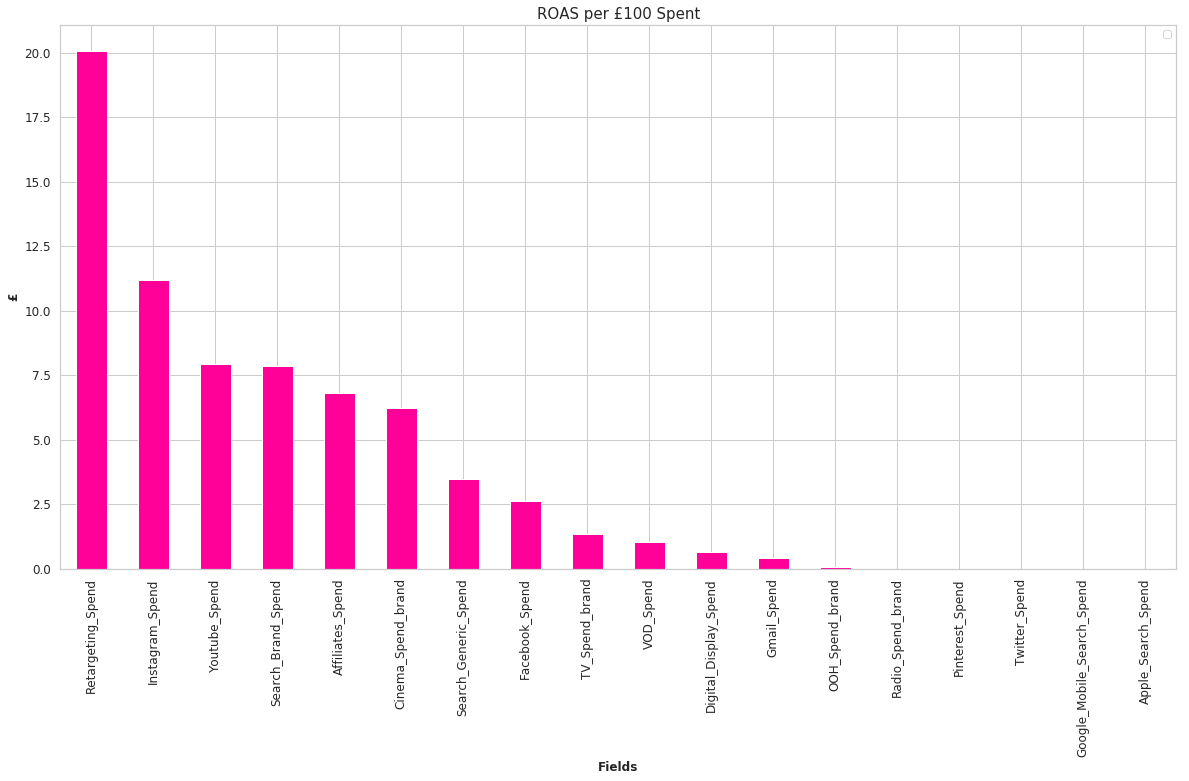

In [99]:
(model_summary[2:].set_index('Fields')*100).plot.bar(figsize=(20,10),cmap=my_cmap)
plt.title('ROAS per £100 Spent')
plt.ylabel('£')
plt.legend([])

# Decomposition

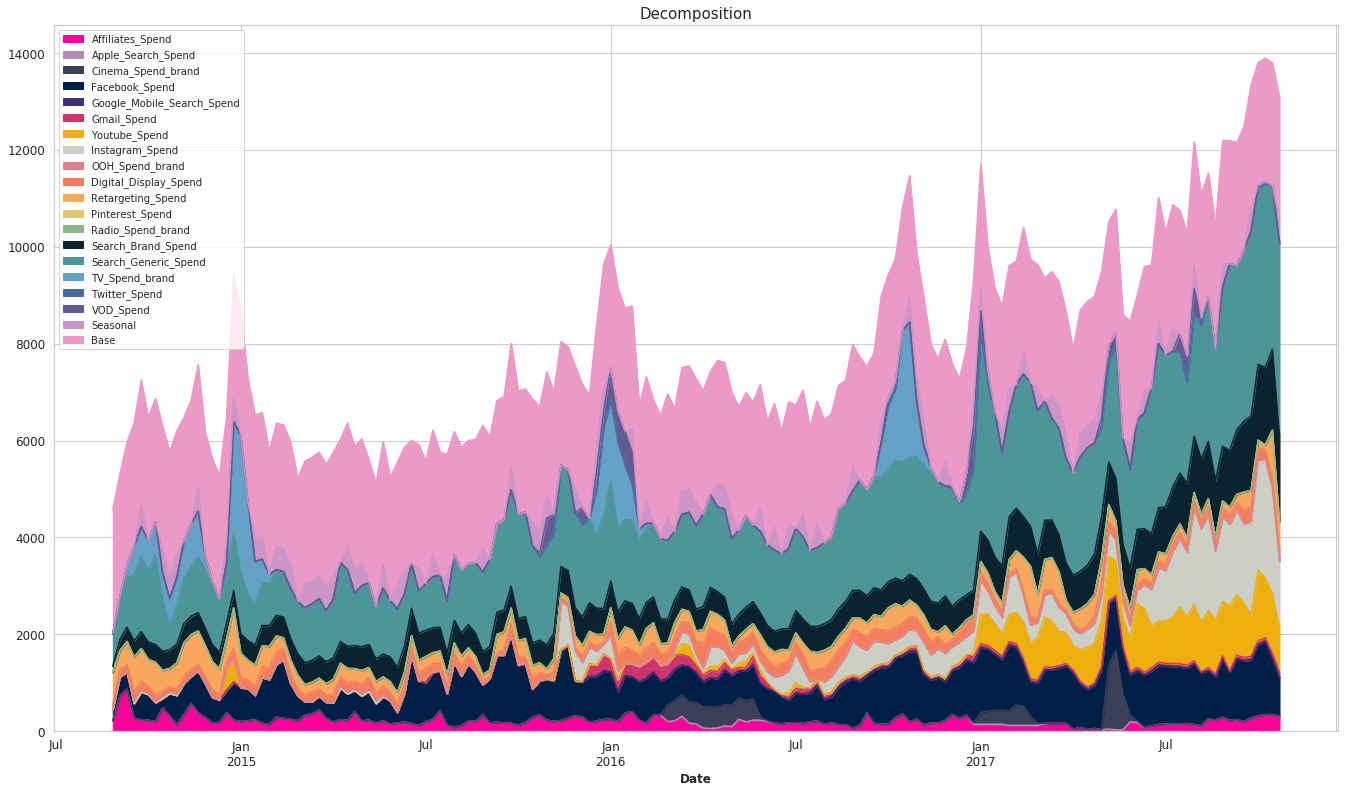

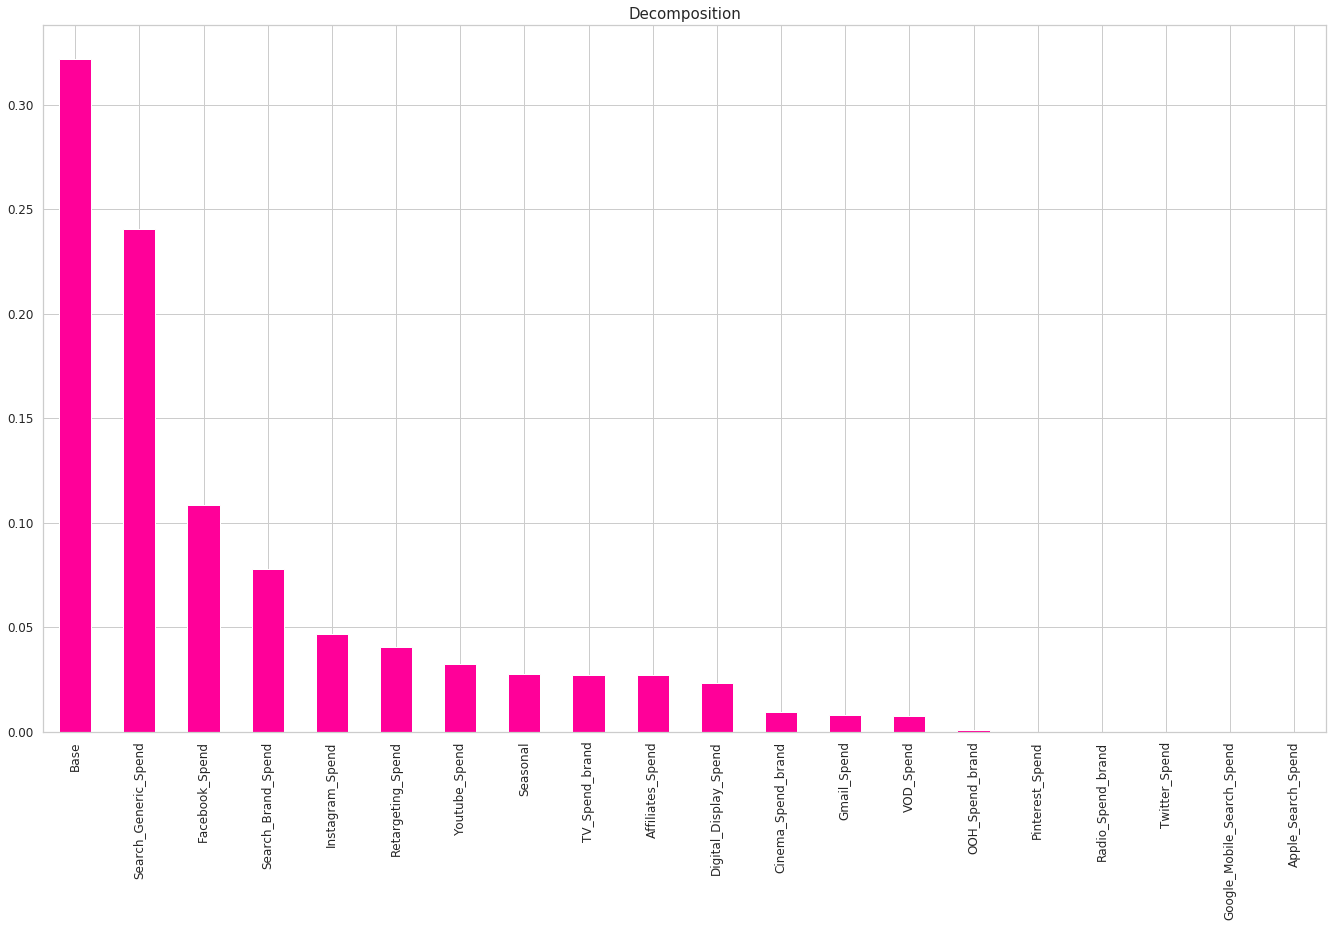

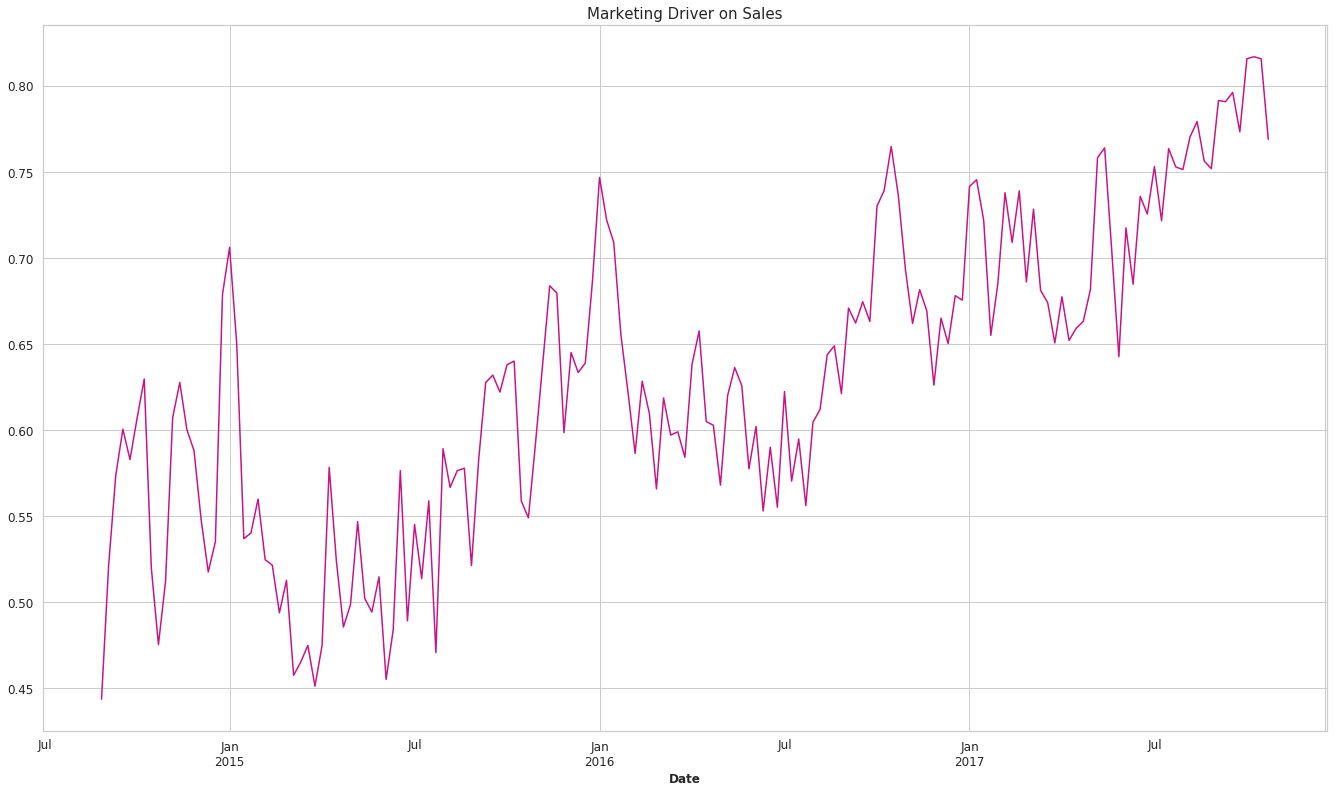

In [100]:
decomp = econ.decomp.Decompose_model(df,independent,model_summary)
econ.decomp.Decompose_plots(decomp,my_cmap=my_cmap)

# Senario

In [143]:
def Plot_ROAS_vs_Potentail(decomp,model_summary,spends,loc=None):
    roas_vs_cap = pd.DataFrame()
    df = model_summary[model_summary['Fields'].isin(spends)]
    df_decomp = decomp[spends]
    
    roas_df = pd.DataFrame()
    
    roas_df = df[df['Coef'] > 0].set_index('Fields')*100
    cap_df = pd.DataFrame(df_decomp.max() - df_decomp.mean()).dropna().rename(columns={0:'Growth'})
    cap_df['Current Sales']  = pd.DataFrame(df_decomp.mean()).dropna()

    roas_vs_cap = roas_df.join(cap_df)

    x = roas_vs_cap['Coef'].values
    y = roas_vs_cap['Growth'].values/roas_vs_cap['Current Sales'].values
    y1 = roas_vs_cap['Current Sales'].values

    n = roas_vs_cap.index.values

    fig, ax = plt.subplots(figsize=(20,6.5))

    plt.scatter(x,y,s=200, c=color_dict['pink'], alpha=0)

    plt.xlabel('ROAS per £100', fontsize=18)
    plt.ylabel('Potentail Growth (x * current sales)', fontsize=18)

    plt.title('ROAS vs. Potentail Growth', fontsize=18)

    for i, txt in enumerate(n):
        ax.annotate(txt.lower().replace('brand','').replace('_spend','').replace('_',' ').title(), (x[i], y[i]), fontsize=15)
        #ax.annotate(txt.lower().replace('brand','').replace('_spend','').replace('_',' ').title(), (x[i], y1[i]), fontsize=15,color=color_dict['pink'])
    sns.despine()

    if loc == None:
        pass
    else:
        fig.savefig(loc)
        
    return roas_vs_cap
    

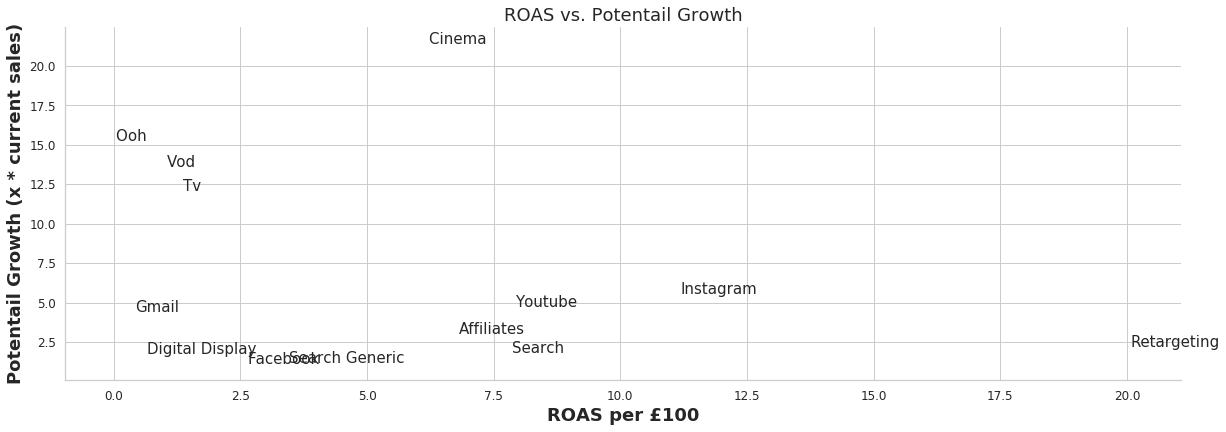

In [145]:
sps = list(model_summary['Fields'].values)
sps.remove('Intercept')
sps.remove('Seasonal')
recs_df = Plot_ROAS_vs_Potentail(decomp,model_summary,sps,loc='test.png')

## Build Deck

In [102]:
from pptx import Presentation
from pptx.chart.data import XyChartData
from pptx.enum.chart import XL_CHART_TYPE
from pptx.util import Inches,Cm
from pptx.dml.color import RGBColor
from pptx.enum.chart import XL_LABEL_POSITION

# create presentation with 1 slide ------
prs = Presentation('../Template.pptx')


chart_data = XyChartData()
slide = prs.slides.add_slide(prs.slide_layouts[31])
title = slide.shapes.title
title.text = "Channel Focus"

pic = slide.shapes.add_picture('test.png', Cm(0.89), Cm(3.04),
                               width=Cm(31), height=Cm(14))


prs.save('chart-01.pptx')


In [ ]:
roas_vs_cap = roas_vs_cap[['Coef','Reach Index']]

In [ ]:
roas_vs_cap['Coef']/roas_vs_cap['Coef'].mean()

In [103]:
roas_vs_cap

,Coef,Reach Index,Sales
Fields,,,
Retargeting_Spend,20.063485,711.704091,318.957121
Instagram_Spend,11.185166,2054.119799,370.600476
Youtube_Spend,7.946423,1205.337557,254.499856
Search_Brand_Spend,7.861127,1128.593419,613.347367
Affiliates_Spend,6.819491,651.513114,215.380612
Cinema_Spend_brand,6.230756,1567.595224,73.167201
Search_Generic_Spend,3.465139,2255.304046,1899.709196
Facebook_Spend,2.635678,960.115617,857.764402
TV_Spend_brand,1.361038,2613.536750,215.772485
